We wil showcase the three TDA vectorization procedures, by applying them to an example TIMIT audio file ("LDC93S1.wav") from https://catalog.ldc.upenn.edu/LDC93S1.

In [1]:
import numpy as np
import soundfile as sf
from ripser import ripser
import scipy
import matplotlib.pyplot as plt
import librosa
from librosa.core import spectrum

from stat_sum import stat_feats

In [2]:
# plotting functions:

def plot_aud(arr, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.plot(arr, linewidth = 2.5, color = 'black')
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.title(title, fontsize=35)
    plt.xlabel('Samples', fontsize=25)
    plt.ylabel('Amplitude', fontsize=25)
    fig.show()

def create_PD(BDs, title):
    f, ax = plt.subplots(figsize=(10, 10))
    maxval = 0
    minval = 0
    legend_lst = []
    for idx, BD in enumerate(BDs.values()):
        ax.scatter(BD[:,0], BD[:,1], s = 250, alpha = .35)
        maxval = max(maxval, np.max(BD[:,1]),np.max(BD[:,0]))
        minval = min(minval, np.min(BD[:,1]), np.min(BD[:,0]))
        legend_lst.append(f"$H_{idx}$")

    plt.legend(legend_lst, loc="lower right", fontsize = 35)
    ax.plot([minval, maxval], [minval, maxval], ls="--", c=".3", linewidth = 3.5)
    ax.set_xlabel("Birth", fontsize = 25)
    ax.set_ylabel("Death", fontsize = 25)
    ax.set_xticks(ax.get_xticks()[1::2])
    ax.set_yticks(ax.get_yticks()[1::2])
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.title(title, fontsize=35)
    f.show()

def plot_stat(vect, title):
    fig, ax = plt.subplots(figsize=(10, 10))

    width = 0.85
    counts = vect
    ind = range(len(counts))
    ax.bar(x=ind, height=vect, width=width,align='center', label = '$H_0$')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xticks([idx * 9 for idx in range(5)] + [4*9 + 2])

    ax.legend(prop={'size': 25},loc="lower right")#,ncol = 3,columnspacing=0.5)
    if 'aud' in title:
        plt.yscale('symlog', linthresh =1e-3)
    plt.title(title, fontsize=35)
    plt.show()

    
def plot_takens_vect(PD, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    width = 0.85

    counts0 = PD[0]
    counts1 = PD[1]
    counts2 = PD['combination']
    bars = [counts0, counts1, counts2]
    start = 0
    starts = []
    for idx, bar in enumerate(bars):
        ind = np.arange(len(bar))
        ind += start
        starts.append(start)
        start = ind[-1] + 1
        if idx == 2:
            label = 'comb'
        else:
            label = f'$H_{idx}$'
        ax.bar(x=ind, height=bar, width=width, align='center', label = label)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.yscale('symlog', linthresh =1e-3)
    ax.set_xticks(starts + [idz * 10 for idz in range(8) if min([abs(s - idz * 10) for s in starts]) > 5])
    ax.legend(prop={'size': 25},loc="lower center")
    ax.get_xticklabels()[0].set_color("tab:blue")
    ax.get_xticklabels()[0].set_weight("bold")
    ax.get_xticklabels()[1].set_color("tab:orange")
    ax.get_xticklabels()[1].set_weight("bold")
    ax.get_xticklabels()[2].set_color("tab:green")
    ax.get_xticklabels()[2].set_weight("bold")
    plt.title(title, fontsize=35)
    fig.show()

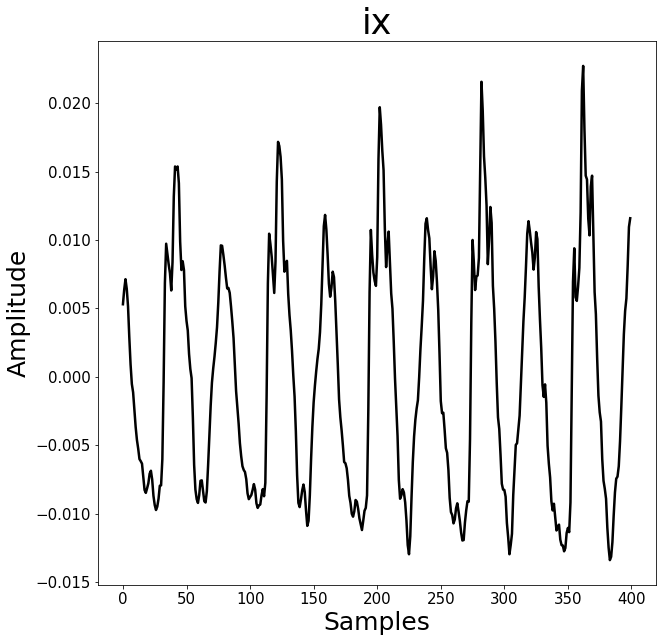

In [3]:
exaud, sr = sf.read("./LDC93S1.wav")

# using the provided alignment file, we can select the first 25 ms of two phones, ix and s
ix_aud = exaud[24229 : 24229 + 400]

plot_aud(ix_aud, 'ix')

## TDAmel

In [4]:
def make_mel_spect(input_window, ws, shift_per, n_mels = 40, wf = 'hann'):
    ws_samps = int(16000 / 1000 * ws)
    return librosa.power_to_db(librosa.feature.melspectrogram(y=input_window, sr=16000, n_fft = ws_samps,
                  hop_length = int(ws_samps * (1 - shift_per)), n_mels=n_mels), ref=np.max)

/home1/s3468720/.local/lib/python3.10/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


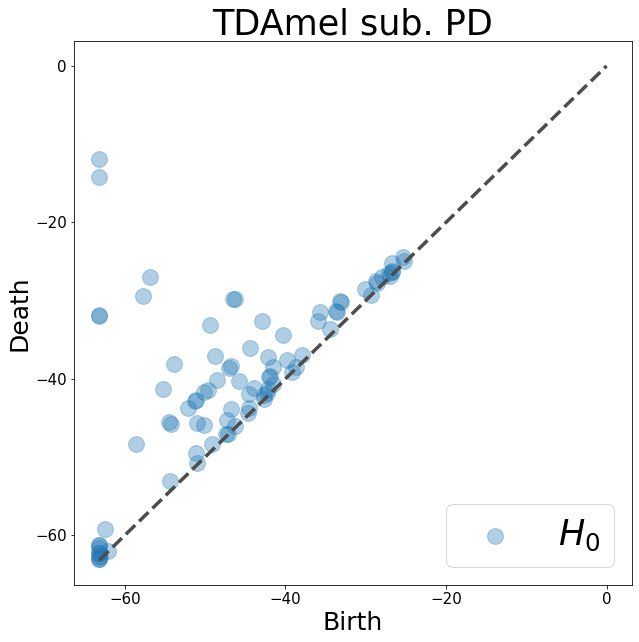

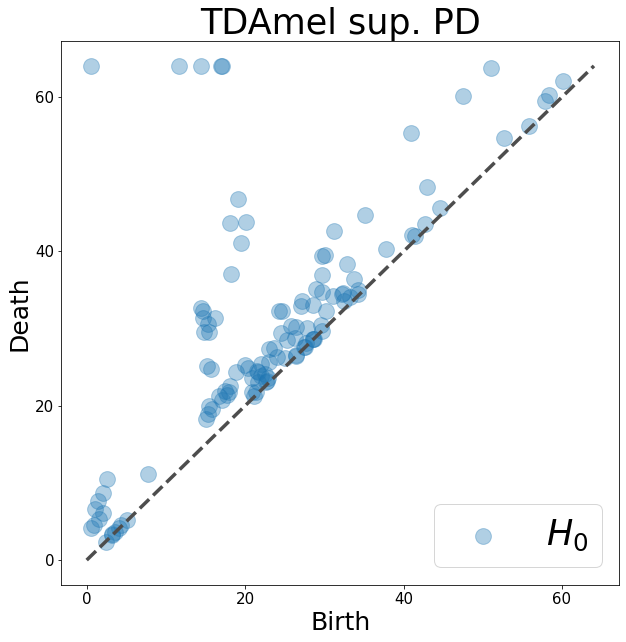

In [5]:
# creating the persistence diagrams:
from make_pds import sub_lvl_2d

ix_sub_PD = sub_lvl_2d(make_mel_spect(ix_aud, 3, .95, n_mels = 30))
  # the suplevel set filtration is just the subfiltration of the
  # inverted surface (up to a translation)
ix_sup_PD = sub_lvl_2d(-make_mel_spect(ix_aud, 3, .95, n_mels = 40))

create_PD(ix_sub_PD, 'TDAmel sub. PD')
create_PD(ix_sup_PD, 'TDAmel sup. PD')

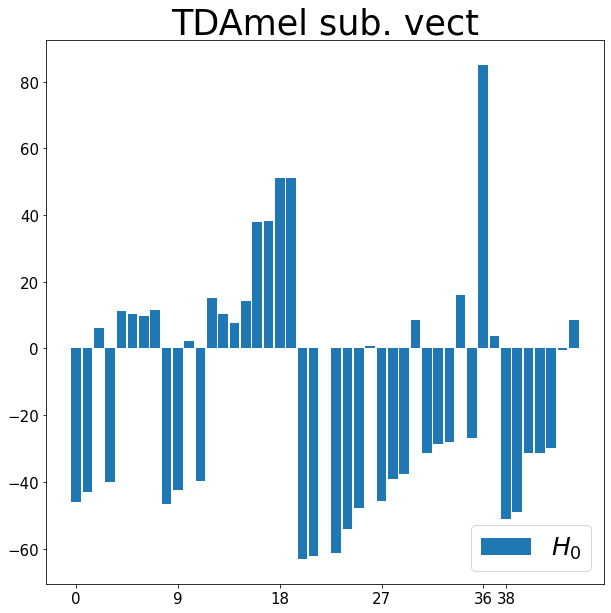

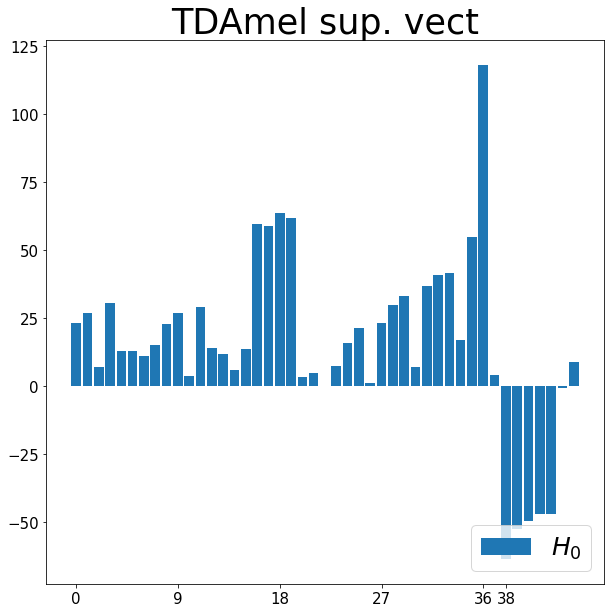

In [6]:
# creating the vectorizations:
ix_sub_vect = stat_feats(ix_sub_PD, ext = True, red0 = False)
ix_sup_vect = stat_feats(ix_sup_PD, ext = True, red0 = False)

plot_stat(ix_sub_vect[0], 'TDAmel sub. vect')
plot_stat(ix_sup_vect[0], 'TDAmel sup. vect')

## TDAaud

In [7]:
from scipy.signal.windows import hamming

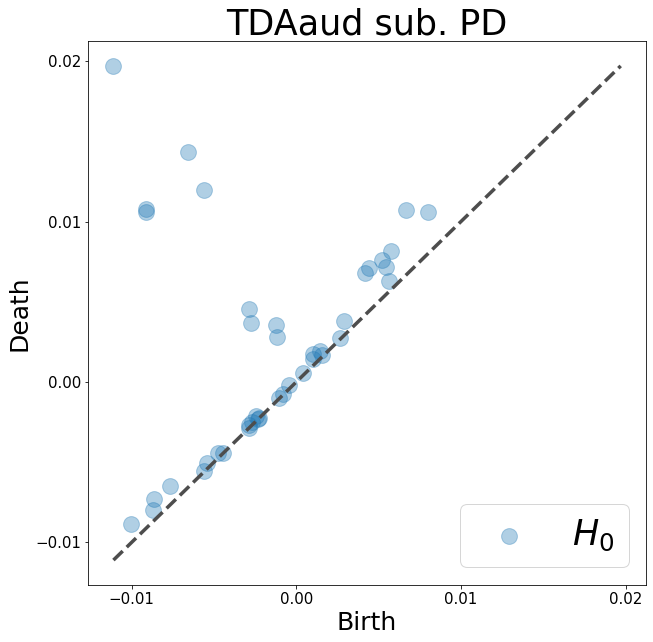

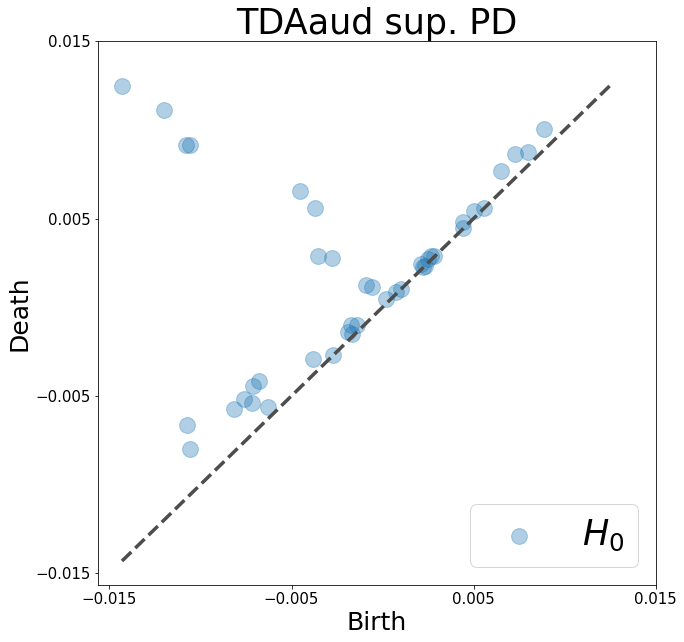

In [8]:
# creating the persistence diagrams:
import scipy
from make_pds import sub_lvl_1d

ix_sub_aud_PD = sub_lvl_1d(ix_aud * hamming(ix_aud.size))
ix_sup_aud_PD = sub_lvl_1d(-ix_aud * hamming(ix_aud.size))

create_PD(ix_sub_aud_PD, 'TDAaud sub. PD')
create_PD(ix_sup_aud_PD, 'TDAaud sup. PD')

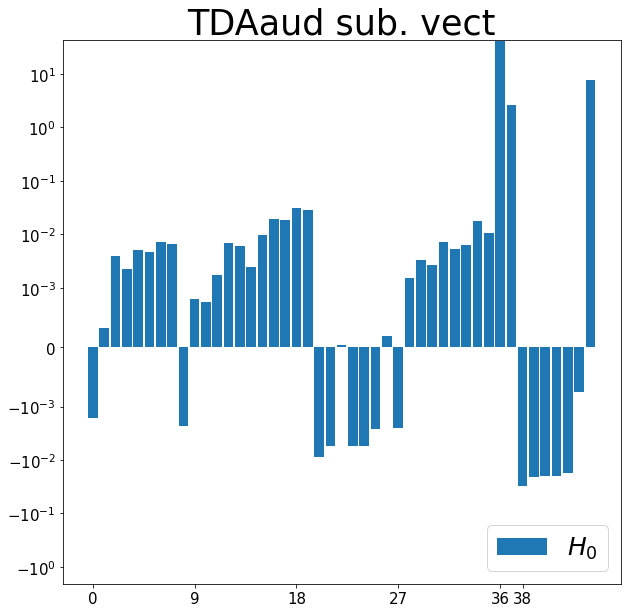

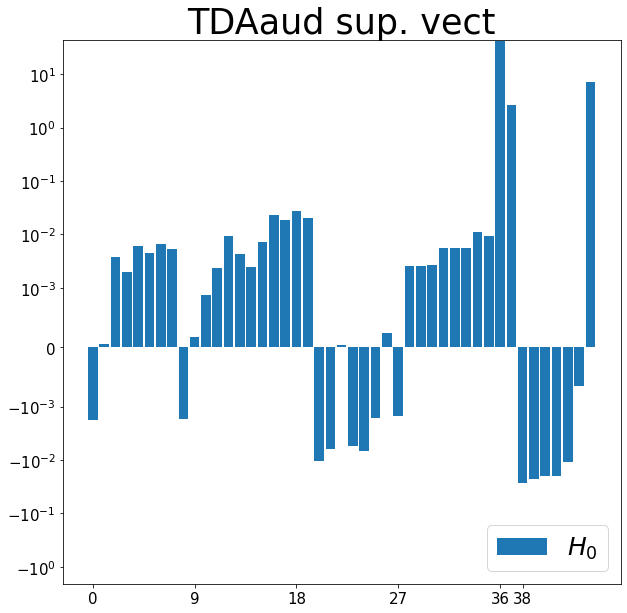

In [9]:
# creating the vectorizations:
ix_sub_vect = stat_feats(ix_sub_aud_PD, ext = True, red0 = False)
ix_sup_vect = stat_feats(ix_sup_aud_PD, ext = True, red0 = False)

plot_stat(ix_sub_vect[0], 'TDAaud sub. vect')
plot_stat(ix_sup_vect[0], 'TDAaud sup. vect')

## TDAtakens

In [10]:
# For simplicity we define anotehr function for calculating the persistence diagram
# using the Viertor Rips filtration, which does not require GPU:
def make_VR_PD(arr):
    diags = ripser(arr)['dgms']
    PD = dict(zip([idx for idx in range(len(diags))], diags))
    PD[0]=PD[0][:-1]
    return PD

from make_pds import single_takens_embed

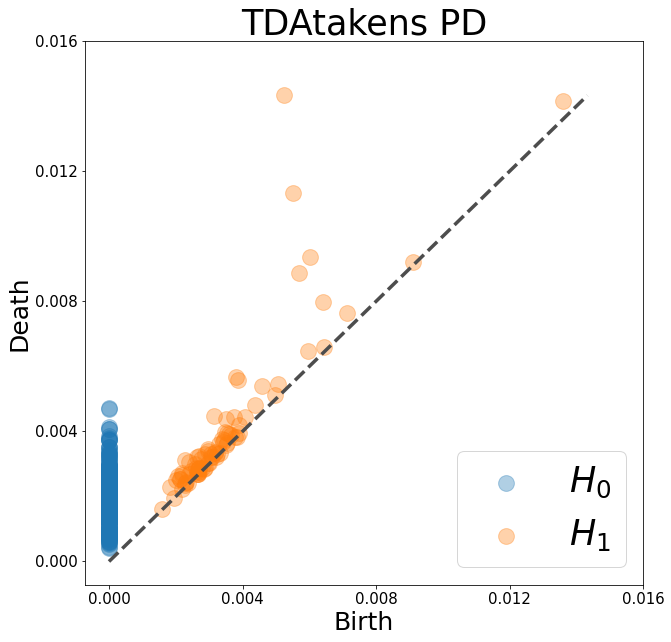

In [11]:
# creating the persistence diagram:
ix_pc = single_takens_embed(ix_aud, 23, 4)
ix_VR_PD = make_VR_PD(ix_pc)

create_PD(ix_VR_PD, 'TDAtakens PD') 

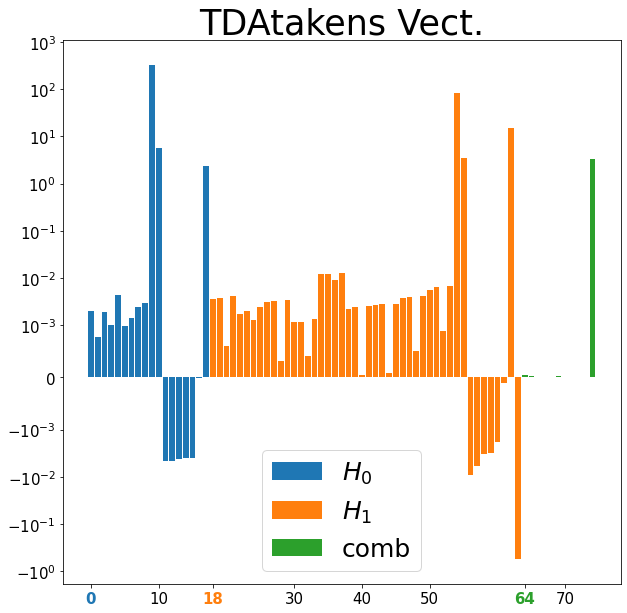

In [12]:
# creating the vectorization:
ix_takens_vect = stat_feats(ix_VR_PD, ext = True, red0 = True)

plot_takens_vect(ix_takens_vect, 'TDAtakens Vect.')